In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob  # finding image paths
import numpy as np  # creating numpy arrays
from skimage.io import imread  # reading images
from skimage.transform import resize  # resizing images
import cv2
import seaborn as sns 
# For reproducibility
np.random.seed(42)

import fnmatch
import os
import pickle as pkl



from sklearn import metrics
import sklearn
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay,f1_score, 
                             recall_score, precision_score, balanced_accuracy_score, RocCurveDisplay)

import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from keras.utils import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Rescaling
from tensorflow.keras import utils
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2



In [2]:
#Code adapted from : https://colab.research.google.com/notebooks/snippets/drive.ipynb#scrollTo=TbRbQAYqPTci

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [4]:
train_label_df=pd.read_csv('/content/drive/MyDrive/GA/Capstone/train_2_reshapedImg_labels3_b.csv')
train_label_df.head()

,image_id,label,level,label_b
0,10003_left,0,No DR,0
1,10003_right,0,No DR,0
2,10007_left,0,No DR,0
3,10007_right,0,No DR,0
4,10009_left,0,No DR,0


In [5]:
train_label_df['label_b'].value_counts()

0    21279
1     7581
Name: label_b, dtype: int64

In [6]:
pos=train_label_df['label_b'].value_counts()[1]
neg=train_label_df['label_b'].value_counts()[0]
pos,neg

(7581, 21279)

In [7]:
initial_bias = np.log([pos/neg])
initial_bias

array([-1.03207555])

In [8]:
test_label_df=pd.read_csv('/content/drive/MyDrive/GA/Capstone/test_reshapedImg_labels_b.csv')
test_label_df.head()

,image_id,label,level,label_b
0,29127_left,0,No DR,0
1,29127_right,0,No DR,0
2,29132_left,0,No DR,0
3,29132_right,0,No DR,0
4,29135_left,0,No DR,0


In [9]:
test_label_df['label_b'].value_counts()

0    2774
1    1048
Name: label_b, dtype: int64

In [10]:
index_to_level={0:'No DR', 1:'Mild DR',2:'Moderate DR',3:'Severe DR',4:'Proliferative DR'}
index_to_level

{0: 'No DR',
 1: 'Mild DR',
 2: 'Moderate DR',
 3: 'Severe DR',
 4: 'Proliferative DR'}

All models fit with batch size of 512 unless otherwise mentioned:  
inresnet (Inception Resnet V2)- 256 batch size

In [12]:
#https://androidkt.com/use-image-dataset-from-directory-with-and-without-label-list-in-keras/

#creating binary train and val batches 

data_dir='/content/drive/MyDrive/GA/Capstone/train'
IMG_height = 224
IMG_width = 224
batch_size=512


train_b = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=42,
  labels=train_label_df['label_b'].to_numpy().tolist(),
  label_mode='int',
  # class_names=["0", "1", "2", "3", "4"],
  validation_split=0.2,
  subset="training",
  image_size=(IMG_height, IMG_width),
  batch_size=batch_size,
  shuffle=False)
 
val_b = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=42,
  labels=train_label_df['label_b'].to_numpy().tolist(),
  label_mode='int',
  # class_names=["0", "1", "2", "3", "4"],
  validation_split=0.2,
  subset="validation",
  image_size=(IMG_height, IMG_width),
  batch_size=batch_size,
  shuffle=False)


Found 28860 files belonging to 1 classes.
Using 23088 files for training.
Found 28860 files belonging to 1 classes.
Using 5772 files for validation.


In [13]:
#https://androidkt.com/use-image-dataset-from-directory-with-and-without-label-list-in-keras/

# creating binary test batch

data_dir='/content/drive/MyDrive/GA/Capstone/test_train_3/test_reshapedImg_parent'
IMG_height = 224
IMG_width = 224
batch_size=512




test_b = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=42,
  labels=test_label_df['label_b'].to_numpy().tolist(),
  label_mode='int',
  validation_split=0.0,
  image_size=(IMG_height, IMG_width),
  batch_size=batch_size,
  shuffle=False)


Found 3822 files belonging to 1 classes.


In [14]:
test_true_class_b=test_label_df['label_b'].to_numpy()
print(len(test_true_class_b))
test_true_class_b;

3822


In [15]:
train_true_class_b=train_label_df['label_b'].to_numpy()
print(len(train_true_class_b))
train_true_class_b;

28860


In [16]:

def plot_history(history):
  plt.figure(figsize=(10,10))
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color='b', label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color='r', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    

  return

In [17]:
def get_label(data):
  for image, label in data:
    y=label.numpy()
  return y

In [18]:
# eval_df=pd.DataFrame(columns=['model','training_accuracy','testing_accuracy','best_score','f1score_train','f1score_test','comments'])

def bmodel_eval(model, model_name):
  print('-----TEST--------')
  weighted_results = model.evaluate(test_b, verbose=1)
  for name, value in zip(model.metrics_names, weighted_results):
    print(name, ': ', value)
  print('-------------')


  print('-----VAL--------')
  # val_true_class_b=get_label(val_b)
  weighted_results = model.evaluate(val_b, verbose=1)
  for name, value in zip(model.metrics_names, weighted_results):
    print(name, ': ', value)
  print('-------------')

  test_pred_class=np.round(model.predict(test_b))
  print(len(test_pred_class))
  print(tf.math.confusion_matrix(labels=test_true_class_b, predictions=test_pred_class, num_classes=2))

  cm = tf.math.confusion_matrix(labels=test_true_class_b, predictions=test_pred_class, num_classes=2)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])
  print('Total: ', np.sum(cm[1]))


  print(classification_report(test_true_class_b, test_pred_class))
  
  return

In [19]:
#Generating Class Weights to plugin during CNN model fitting to combat with imbalanced classes

from sklearn.utils import class_weight

weights_b_master=class_weight.compute_class_weight(class_weight='balanced',
                                    classes=np.unique(np.array(train_label_df['label_b'])), 
                                    y=np.array(train_label_df['label_b']))
classes_b_master=np.unique(np.array(train_label_df['label_b']))
weights_b_dict_master=dict(zip(classes_b_master, weights_b_master))
weights_b_dict_master

{0: 0.678133370929085, 1: 1.9034428175702414}

In [21]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [22]:

es=EarlyStopping(monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

### CNN1 Binary Classification (adapted from CNN3 multi class)
metrics  
setting initial bias  
bigger batch size=512  
help from https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [ ]:


model1_b=Sequential()

# Add a convolutional layer.

model1_b.add(Rescaling(1./255, input_shape=(IMG_height, IMG_width,3)))

model1_b.add(Conv2D(filters=64,            
                     kernel_size=(3, 3),        
                     activation='relu'    
                    )) 
model1_b.add(Conv2D(filters=64,            
                     kernel_size=(3, 3),        
                     activation='relu'    
                    )) 
model1_b.add(MaxPooling2D(pool_size=(2, 2)))


model1_b.add(Conv2D(filters=128,            
                     kernel_size=(3, 3),        
                     activation='relu'    
                    )) 
model1_b.add(Conv2D(128,
                  kernel_size = (3, 3),
                  activation='relu'))
model1_b.add(Conv2D(128,
                  kernel_size = (1, 1),
                  activation='relu'))
model1_b.add(MaxPooling2D(pool_size=(2,2)))



model1_b.add(Conv2D(256,
                  kernel_size = (3, 3),
                  activation='relu'))
model1_b.add(Conv2D(256,
                  kernel_size = (3, 3),
                  activation='relu'))
model1_b.add(Conv2D(256,
                  kernel_size = (1, 1),
                  activation='relu'))
model1_b.add(MaxPooling2D(pool_size=(2,2)))




model1_b.add(Flatten())


model1_b.add(Dense(128,
                activation='relu', kernel_regularizer=l2(0.005)))
model1_b.add(Dropout(0.5))


model1_b.add(Dense(256,
                activation='relu', kernel_regularizer=l2(0.005)))
model1_b.add(Dropout(0.5))


model1_b.add(Dense(256,
                activation='relu', kernel_regularizer=l2(0.005)))
model1_b.add(Dropout(0.5))


model1_b.add(Dense(1,
                 activation='sigmoid',
                 bias_initializer=tf.keras.initializers.Constant(initial_bias)))


model1_b.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  metrics=METRICS,
              )

In [ ]:
model1_b.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 conv2d_17 (Conv2D)          (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 110, 110, 64)     0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 108, 108, 128)     73856     
                                                                 
 conv2d_19 (Conv2D)          (None, 106, 106, 128)     147584    
                                                      

In [ ]:
history_model1_b=model1_b.fit(train_b,
                            validation_data=val_b,
                            epochs=20,
                            verbose=1,
                            callbacks=[es])


model1_b.save('/content/drive/MyDrive/GA/Capstone/BinaryModels/model1_b.h5')

with open('/content/drive/MyDrive/GA/Capstone/BinaryModels/model1_b_history.pkl','wb') as model_history:
  pkl.dump(history_model1_b, model_history)


In [23]:
model1_b=tf.keras.models.load_model('/content/drive/MyDrive/GA/Capstone/BinaryModels/model1_b.h5')

with open('/content/drive/MyDrive/GA/Capstone/BinaryModels/model1_b_history.pkl','rb') as model_history:
  history_model1_b=pkl.load(model_history)


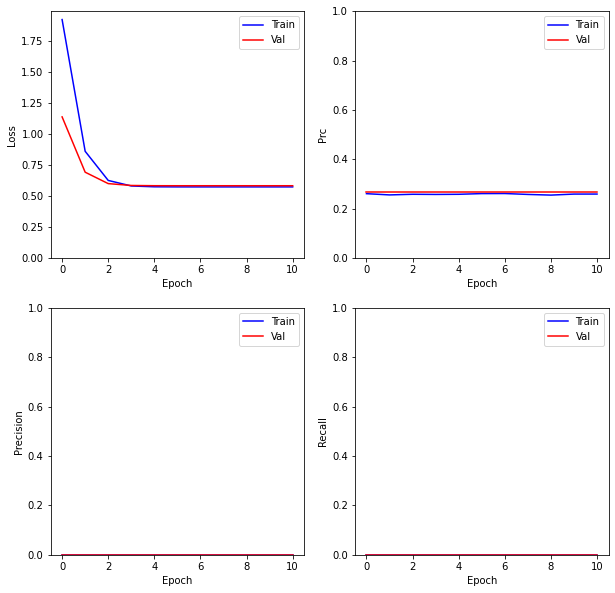

In [24]:
plot_history(history_model1_b)

-----TEST--------
8/8 [==============================] - 126s 13s/step - loss: 1.1416 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2774.0000 - fn: 1048.0000 - accuracy: 0.7258 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.2742
loss :  1.1416128873825073
tp :  0.0
fp :  0.0
tn :  2774.0
fn :  1048.0
accuracy :  0.7257980108261108
precision :  0.0
recall :  0.0
auc :  0.5
prc :  0.27420198917388916
-------------
-----VAL--------
12/12 [==============================] - 153s 13s/step - loss: 1.1372 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4214.0000 - fn: 1558.0000 - accuracy: 0.7301 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.2699
loss :  1.1371620893478394
tp :  0.0
fp :  0.0
tn :  4214.0
fn :  1558.0
accuracy :  0.730076253414154
precision :  0.0
recall :  0.0
auc :  0.5
prc :  0.26992377638816833
-------------
8/8 [==============================] - 4s 546ms/step
3822
tf.Tensor(
[[2774    0]
 [1048    0]], shape=(2, 2), dtype=int32)
True Negatives

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


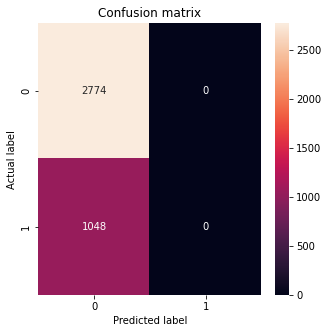

In [25]:
bmodel_eval(model1_b,'Model1 b CNN')

### CNN weighted model

In [ ]:
history_model1_b_weighted=model1_b.fit(train_b,
                            validation_data=val_b,
                            epochs=20,
                            verbose=1,
                            callbacks=[es],
                            class_weight=weights_b_dict_master)

Epoch 1/20
46/46 [==============================] - 53s 1s/step - loss: 2.3529 - tp: 1212.0000 - fp: 3605.0000 - tn: 13460.0000 - fn: 4811.0000 - accuracy: 0.6355 - precision: 0.2516 - recall: 0.2012 - auc: 0.4942 - prc: 0.2576 - val_loss: 1.4989 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 4214.0000 - val_fn: 1558.0000 - val_accuracy: 0.7301 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5169 - val_prc: 0.2786
Epoch 2/20
46/46 [==============================] - 50s 1s/step - loss: 1.2613 - tp: 1697.0000 - fp: 4838.0000 - tn: 12227.0000 - fn: 4326.0000 - accuracy: 0.6031 - precision: 0.2597 - recall: 0.2818 - auc: 0.4982 - prc: 0.2597 - val_loss: 0.9658 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 4214.0000 - val_fn: 1558.0000 - val_accuracy: 0.7301 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5283 - val_prc: 0.2949
Epoch 3/20
46/46 [==============================] - 50s 1s/step - loss: 0.9133 - tp: 1733.0000 - fp: 4908.0000 - tn: 1

In [ ]:
model1_b.save('/content/drive/MyDrive/GA/Capstone/BinaryModels/model1_b_weighted.h5')

with open('/content/drive/MyDrive/GA/Capstone/BinaryModels/model1_b_weighted_history.pkl','wb') as model_history:
  pkl.dump(history_model1_b_weighted, model_history)

In [26]:
model1_bW=tf.keras.models.load_model('/content/drive/MyDrive/GA/Capstone/BinaryModels/model1_b_weighted.h5')

with open('/content/drive/MyDrive/GA/Capstone/BinaryModels/model1_b_weighted_history.pkl','rb') as model_history:
  history_model1_bW=pkl.load(model_history)


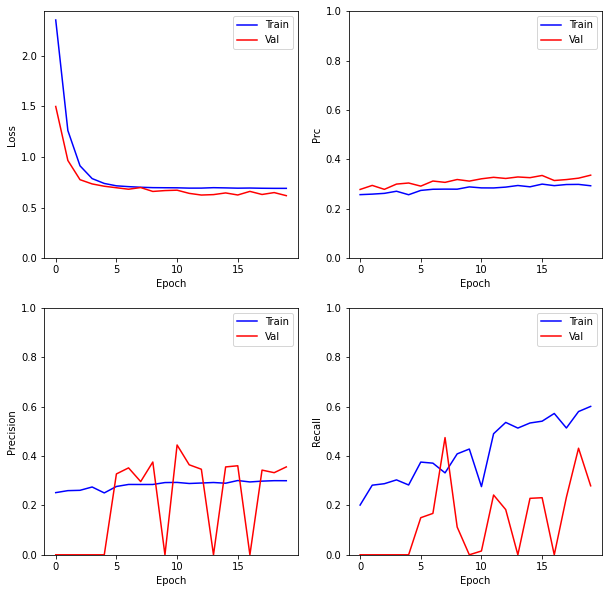

In [27]:
plot_history(history_model1_bW)

-----TEST--------
8/8 [==============================] - 7s 773ms/step - loss: 0.6207 - tp: 299.0000 - fp: 522.0000 - tn: 2252.0000 - fn: 749.0000 - accuracy: 0.6675 - precision: 0.3642 - recall: 0.2853 - auc: 0.5949 - prc: 0.3416
loss :  0.6207068562507629
tp :  299.0
fp :  522.0
tn :  2252.0
fn :  749.0
accuracy :  0.6674516201019287
precision :  0.364190012216568
recall :  0.28530535101890564
auc :  0.5949430465698242
prc :  0.34156909584999084
-------------
-----VAL--------
12/12 [==============================] - 6s 500ms/step - loss: 0.6183 - tp: 435.0000 - fp: 788.0000 - tn: 3426.0000 - fn: 1123.0000 - accuracy: 0.6689 - precision: 0.3557 - recall: 0.2792 - auc: 0.5936 - prc: 0.3364
loss :  0.6183128356933594
tp :  435.0
fp :  788.0
tn :  3426.0
fn :  1123.0
accuracy :  0.6689189076423645
precision :  0.35568276047706604
recall :  0.2792041003704071
auc :  0.59355229139328
prc :  0.33640390634536743
-------------
8/8 [==============================] - 6s 796ms/step
3822
tf.Tenso

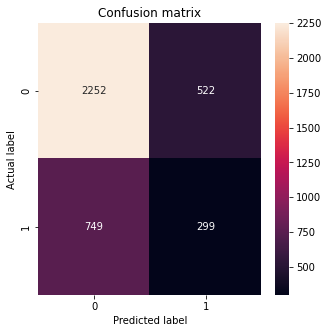

In [28]:
bmodel_eval(model1_bW, 'Model1 b CNN weighted')

# Transfer Learning


In [ ]:
!pip install --upgrade tensorflow_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


trained on (train1, train_2, train_3, train_4)

In [ ]:
feature_extractor='https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'

In [ ]:
feature_extractor_layer=hub.KerasLayer(feature_extractor, input_shape=(224,224,3))

In [ ]:
feature_extractor_layer.trainable=False

In [ ]:
es=EarlyStopping(monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

model2_b_mn=Sequential()

model2_b_mn.add(feature_extractor_layer)

model2_b_mn.add(Dropout(0.5))

model2_b_mn.add(Dense(1, activation='sigmoid'))


model2_b_mn.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  metrics=METRICS,
              )


In [ ]:
model2_b_mn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
history_model2_b_mn=model2_b_mn.fit(train_b,
                            validation_data=val_b,
                            epochs=20,
                            verbose=1,
                            # callbacks=[es]
                            )

model2_b_mn.save('/content/drive/MyDrive/GA/Capstone/BinaryModels/model2_b_mn.h5')

with open('/content/drive/MyDrive/GA/Capstone/BinaryModels/model2_b_mn_history.pkl','wb') as model_history:
  pkl.dump(history_model2_b_mn, model_history)

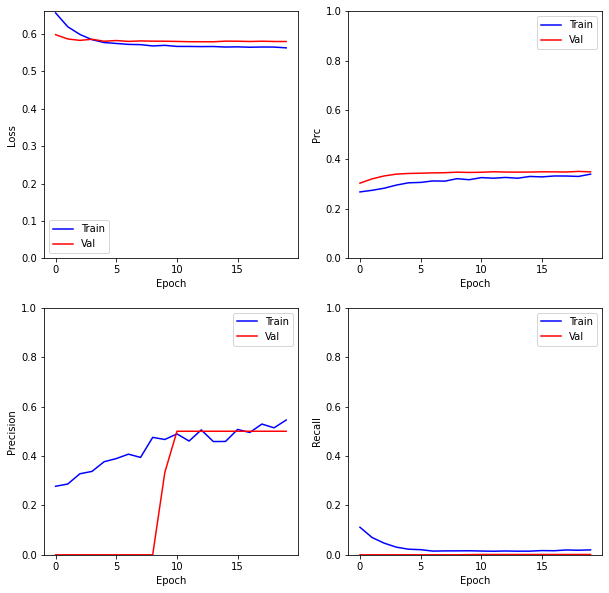

In [ ]:
plot_history(history_model2_b_mn)

-----TEST--------
8/8 [==============================] - 528s 65s/step - loss: 0.5805 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2774.0000 - fn: 1048.0000 - accuracy: 0.7258 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6210 - prc: 0.3791
loss :  0.5804720520973206
tp :  0.0
fp :  0.0
tn :  2774.0
fn :  1048.0
accuracy :  0.7257980108261108
precision :  0.0
recall :  0.0
auc :  0.6209546327590942
prc :  0.37913987040519714
-------------
-----VAL--------
12/12 [==============================] - 17s 1s/step - loss: 0.5798 - tp: 2.0000 - fp: 2.0000 - tn: 4212.0000 - fn: 1556.0000 - accuracy: 0.7301 - precision: 0.5000 - recall: 0.0013 - auc: 0.5994 - prc: 0.3498
loss :  0.5798137187957764
tp :  2.0
fp :  2.0
tn :  4212.0
fn :  1556.0
accuracy :  0.730076253414154
precision :  0.5
recall :  0.00128369708545506
auc :  0.5994497537612915
prc :  0.3497980535030365
-------------
8/8 [==============================] - 12s 1s/step
3822
tf.Tensor(
[[2774    0]
 [1048    0]], shape=(2, 2), dt

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


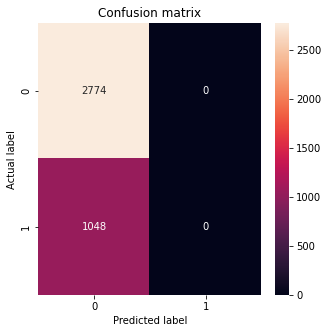

In [ ]:
bmodel_eval(model2_b_mn, 'Model2_b MobileNet')

In [ ]:
history_model2_b_mn_wt=model2_b_mn.fit(train_b,
                            validation_data=val_b,
                            epochs=20,
                            verbose=1,
                            callbacks=[es],
                            class_weight=weights_b_dict_master
                            )

model2_b_mn.save('/content/drive/MyDrive/GA/Capstone/BinaryModels/model2_b_mnWeighted.h5')

with open('/content/drive/MyDrive/GA/Capstone/BinaryModels/model2_b_mnWeighted.pkl','wb') as model:
  pkl.dump(model2_b_mn, model)

with open('/content/drive/MyDrive/GA/Capstone/BinaryModels/model2_b_mn_weighted_history.pkl','wb') as model_history:
  pkl.dump(history_model2_b_mn_wt, model_history)


In [30]:
with open('/content/drive/MyDrive/GA/Capstone/BinaryModels/model2_b_mnWeighted.pkl','rb') as model:
  model2_b_mn=pkl.load(model)

with open('/content/drive/MyDrive/GA/Capstone/BinaryModels/model2_b_mn_weighted_history.pkl','rb') as model_history:
  history_model2_b_mn_wt=pkl.load(model_history)

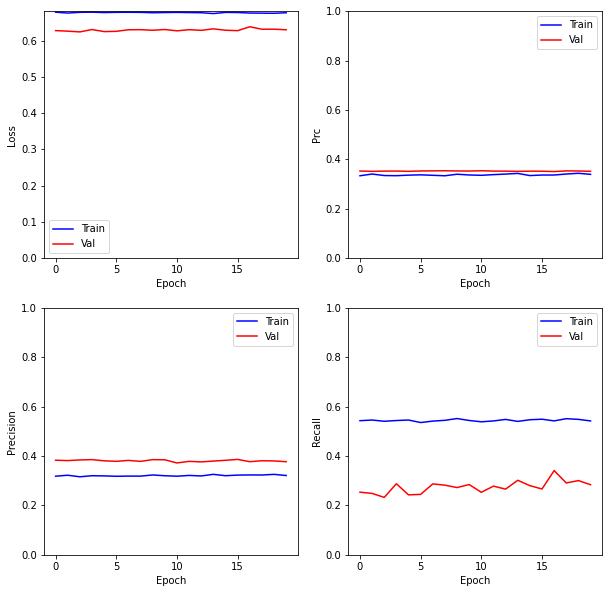

In [31]:
plot_history(history_model2_b_mn_wt)

-----TEST--------
8/8 [==============================] - 6s 467ms/step - loss: 0.6257 - tp: 330.0000 - fp: 448.0000 - tn: 2326.0000 - fn: 718.0000 - accuracy: 0.6949 - precision: 0.4242 - recall: 0.3149 - auc: 0.6290 - prc: 0.3844
loss :  0.6256547570228577
tp :  330.0
fp :  448.0
tn :  2326.0
fn :  718.0
accuracy :  0.6949241161346436
precision :  0.4241645336151123
recall :  0.3148854970932007
auc :  0.6290175318717957
prc :  0.38439035415649414
-------------
-----VAL--------
12/12 [==============================] - 5s 418ms/step - loss: 0.6296 - tp: 442.0000 - fp: 731.0000 - tn: 3483.0000 - fn: 1116.0000 - accuracy: 0.6800 - precision: 0.3768 - recall: 0.2837 - auc: 0.6048 - prc: 0.3519
loss :  0.629603385925293
tp :  442.0
fp :  731.0
tn :  3483.0
fn :  1116.0
accuracy :  0.6800069212913513
precision :  0.37681159377098083
recall :  0.2836970388889313
auc :  0.6047981381416321
prc :  0.3519359230995178
-------------
8/8 [==============================] - 3s 377ms/step
3822
tf.Tenso

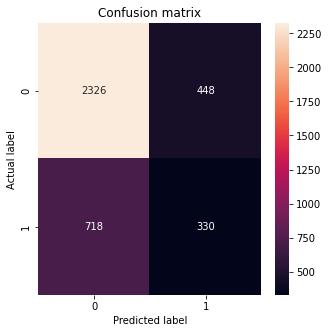

In [32]:
bmodel_eval(model2_b_mn, 'Model2_b MN weighted')

### VGG

Code adapted from https://github.com/krishnaik06/Transfer-Learning/blob/master/face_Recognition.py

In [ ]:
vgg16 = VGG16(input_shape=[224,224] + [3], weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 5s 0us/step


In [ ]:
for layer in vgg16.layers:
  layer.trainable = False

In [ ]:
x = Flatten()(vgg16.output)

prediction = Dense(1, activation='sigmoid')(x)

model3b_vgg = Model(inputs=vgg16.input, outputs=prediction)

model3b_vgg.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  metrics=METRICS,
              )
              
model3b_vgg.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
history_model3b_vgg = model3b_vgg.fit(train_b,
                            validation_data=val_b,
                            epochs=11,
                            verbose=1                            
                            )

model3b_vgg.save('/content/drive/MyDrive/GA/Capstone/BinaryModels/model3b_vgg.h5')

with open('/content/drive/MyDrive/GA/Capstone/BinaryModels/model3b_vgg_history.pkl','wb') as model_history:
  pkl.dump(history_model3b_vgg, model_history)

Epoch 1/11
46/46 [==============================] - 1707s 37s/step - loss: 2.6959 - tp: 1946.0000 - fp: 3951.0000 - tn: 13114.0000 - fn: 4077.0000 - accuracy: 0.6523 - precision: 0.3300 - recall: 0.3231 - auc: 0.5622 - prc: 0.3121 - val_loss: 1.4888 - val_tp: 243.0000 - val_fp: 269.0000 - val_tn: 3945.0000 - val_fn: 1315.0000 - val_accuracy: 0.7256 - val_precision: 0.4746 - val_recall: 0.1560 - val_auc: 0.5990 - val_prc: 0.3881
Epoch 2/11
46/46 [==============================] - 28s 601ms/step - loss: 1.0852 - tp: 2406.0000 - fp: 3054.0000 - tn: 14011.0000 - fn: 3617.0000 - accuracy: 0.7111 - precision: 0.4407 - recall: 0.3995 - auc: 0.6581 - prc: 0.4293 - val_loss: 1.1357 - val_tp: 585.0000 - val_fp: 983.0000 - val_tn: 3231.0000 - val_fn: 973.0000 - val_accuracy: 0.6611 - val_precision: 0.3731 - val_recall: 0.3755 - val_auc: 0.6109 - val_prc: 0.3782
Epoch 3/11
46/46 [==============================] - 28s 602ms/step - loss: 0.7379 - tp: 2781.0000 - fp: 2593.0000 - tn: 14472.0000 - fn: 

In [35]:
model3b_vgg=tf.keras.models.load_model('/content/drive/MyDrive/GA/Capstone/BinaryModels/model3b_vgg.h5')

# model1_bW=tf.keras.models.load_model('/content/drive/MyDrive/GA/Capstone/BinaryModels/model1_b_weighted.h5')

with open('/content/drive/MyDrive/GA/Capstone/BinaryModels/model3b_vgg_history.pkl','rb') as model_history:
  history_model3b_vgg =pkl.load(model_history)

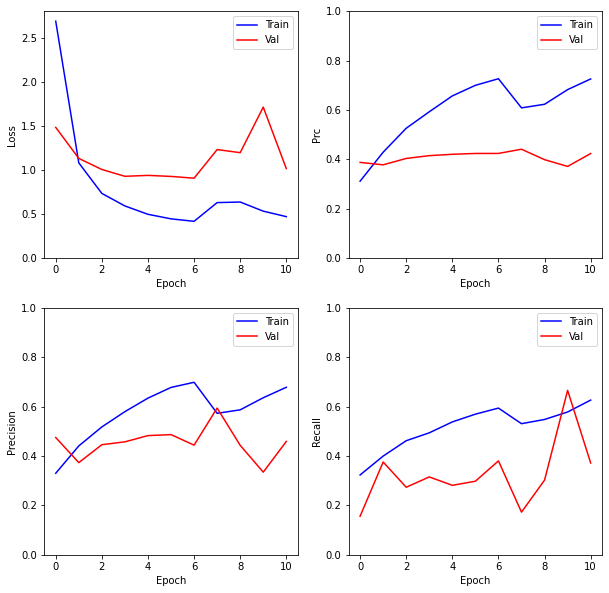

In [34]:
plot_history(history_model3b_vgg)

-----TEST--------
8/8 [==============================] - 16s 937ms/step - loss: 1.0417 - tp: 400.0000 - fp: 475.0000 - tn: 2299.0000 - fn: 648.0000 - accuracy: 0.7062 - precision: 0.4571 - recall: 0.3817 - auc: 0.6527 - prc: 0.4260
loss :  1.0416628122329712
tp :  400.0
fp :  475.0
tn :  2299.0
fn :  648.0
accuracy :  0.7061747908592224
precision :  0.4571428596973419
recall :  0.38167938590049744
auc :  0.6526765823364258
prc :  0.42603182792663574
-------------
-----VAL--------
12/12 [==============================] - 8s 682ms/step - loss: 1.0200 - tp: 579.0000 - fp: 683.0000 - tn: 3531.0000 - fn: 979.0000 - accuracy: 0.7121 - precision: 0.4588 - recall: 0.3716 - auc: 0.6506 - prc: 0.4240
loss :  1.0200086832046509
tp :  579.0
fp :  683.0
tn :  3531.0
fn :  979.0
accuracy :  0.7120581865310669
precision :  0.45879557728767395
recall :  0.3716302812099457
auc :  0.6506440043449402
prc :  0.42402687668800354
-------------
8/8 [==============================] - 5s 627ms/step
3822
tf.Ten

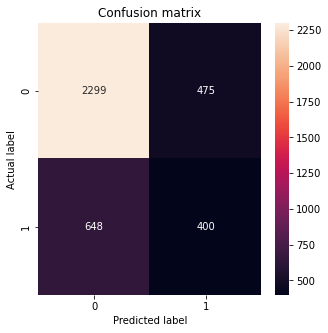

In [36]:
bmodel_eval(model3b_vgg, 'Model3_b VGG16')

### VGG weighted

In [ ]:
es=EarlyStopping(monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

history_model3b_vggW = model3b_vgg.fit(train_b,
                            validation_data=val_b,
                            epochs=25,
                            verbose=1,
                            callbacks=[es],
                            class_weight=weights_b_dict_master                            
                            )

model3b_vgg.save('/content/drive/MyDrive/GA/Capstone/BinaryModels/model3b_vggW.h5')

with open('/content/drive/MyDrive/GA/Capstone/BinaryModels/model3b_vggW_history.pkl','wb') as model_history:
  pkl.dump(history_model3b_vggW, model_history)

Epoch 1/25
46/46 [==============================] - 26s 556ms/step - loss: 0.5093 - tp: 4701.0000 - fp: 3600.0000 - tn: 13465.0000 - fn: 1322.0000 - accuracy: 0.7868 - precision: 0.5663 - recall: 0.7805 - auc: 0.8744 - prc: 0.7425 - val_loss: 1.6065 - val_tp: 1103.0000 - val_fp: 2254.0000 - val_tn: 1960.0000 - val_fn: 455.0000 - val_accuracy: 0.5307 - val_precision: 0.3286 - val_recall: 0.7080 - val_auc: 0.6435 - val_prc: 0.3996
Epoch 2/25
46/46 [==============================] - 25s 549ms/step - loss: 0.7066 - tp: 4505.0000 - fp: 4366.0000 - tn: 12699.0000 - fn: 1518.0000 - accuracy: 0.7451 - precision: 0.5078 - recall: 0.7480 - auc: 0.8342 - prc: 0.6588 - val_loss: 1.1371 - val_tp: 777.0000 - val_fp: 1099.0000 - val_tn: 3115.0000 - val_fn: 781.0000 - val_accuracy: 0.6743 - val_precision: 0.4142 - val_recall: 0.4987 - val_auc: 0.6586 - val_prc: 0.4320
Epoch 3/25
46/46 [==============================] - 26s 553ms/step - loss: 0.6504 - tp: 4632.0000 - fp: 4062.0000 - tn: 13003.0000 - fn

In [37]:
model3b_vggW=tf.keras.models.load_model('/content/drive/MyDrive/GA/Capstone/BinaryModels/model3b_vggW.h5')


with open('/content/drive/MyDrive/GA/Capstone/BinaryModels/model3b_vggW_history.pkl','rb') as model_history:
 history_model3b_vggW =pkl.load(model_history)

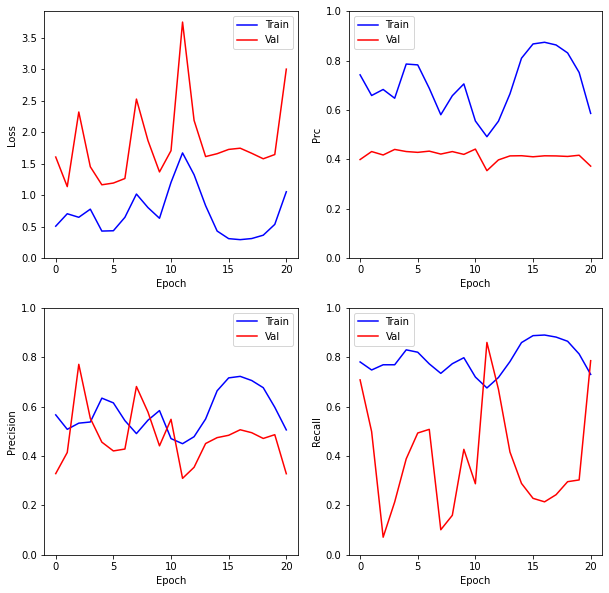

In [38]:
plot_history(history_model3b_vggW)

-----TEST--------
8/8 [==============================] - 6s 586ms/step - loss: 1.7538 - tp: 303.0000 - fp: 290.0000 - tn: 2484.0000 - fn: 745.0000 - accuracy: 0.7292 - precision: 0.5110 - recall: 0.2891 - auc: 0.6487 - prc: 0.4470
loss :  1.7538212537765503
tp :  303.0
fp :  290.0
tn :  2484.0
fn :  745.0
accuracy :  0.7291993498802185
precision :  0.5109612345695496
recall :  0.2891221344470978
auc :  0.6486812829971313
prc :  0.44701245427131653
-------------
-----VAL--------
12/12 [==============================] - 6s 517ms/step - loss: 1.7073 - tp: 448.0000 - fp: 369.0000 - tn: 3845.0000 - fn: 1110.0000 - accuracy: 0.7438 - precision: 0.5483 - recall: 0.2875 - auc: 0.6474 - prc: 0.4419
loss :  1.7072967290878296
tp :  448.0
fp :  369.0
tn :  3845.0
fn :  1110.0
accuracy :  0.7437629699707031
precision :  0.5483475923538208
recall :  0.28754812479019165
auc :  0.6473520398139954
prc :  0.4419245719909668
-------------
8/8 [==============================] - 5s 612ms/step
3822
tf.Tens

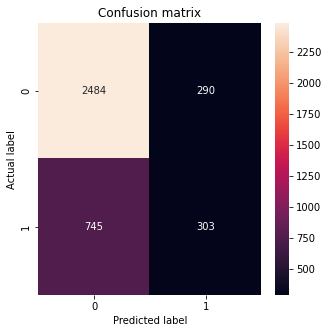

In [39]:
bmodel_eval(model3b_vggW, 'Model3b VGG Weighted')

In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

## ResNet

In [ ]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2  
from keras.applications.inception_resnet_v2 import preprocess_input

In [ ]:
inresnet = InceptionResNetV2(input_shape=[224,224] + [3], weights='imagenet', include_top=False)


219055592/219055592 [==============================] - 11s 0us/step


In [ ]:
for layer in inresnet.layers:
  layer.trainable = False

In [ ]:
x = Flatten()(inresnet.output)

prediction = Dense(1, activation='sigmoid')(x)

model4b_inresnet = Model(inputs=inresnet.input, outputs=prediction)

model4b_inresnet.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  metrics=METRICS,
              )
              
model4b_inresnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

In [ ]:
#ran with batch size=256
history_model4b_inresnet =model4b_inresnet.fit(train_b,
                            validation_data=val_b,
                            epochs=10,
                            verbose=1,
                                                 
                            )

model4b_inresnet.save('/content/drive/MyDrive/GA/Capstone/BinaryModels/model4b_inresnet.h5')

with open('/content/drive/MyDrive/GA/Capstone/BinaryModels/model4b_inresnet_history.pkl','wb') as model_history:
  pkl.dump(history_model4b_inresnet, model_history)

Epoch 1/10
91/91 [==============================] - 2897s 32s/step - loss: 130.2292 - tp: 1556.0000 - fp: 4248.0000 - tn: 12817.0000 - fn: 4467.0000 - accuracy: 0.6225 - precision: 0.2681 - recall: 0.2583 - auc: 0.5048 - prc: 0.2641 - val_loss: 65.9930 - val_tp: 1558.0000 - val_fp: 4211.0000 - val_tn: 3.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.2704 - val_precision: 0.2701 - val_recall: 1.0000 - val_auc: 0.5007 - val_prc: 0.2702
Epoch 2/10
91/91 [==============================] - 157s 2s/step - loss: 54.0744 - tp: 1692.0000 - fp: 4407.0000 - tn: 12658.0000 - fn: 4331.0000 - accuracy: 0.6215 - precision: 0.2774 - recall: 0.2809 - auc: 0.5126 - prc: 0.2695 - val_loss: 19.7758 - val_tp: 92.0000 - val_fp: 158.0000 - val_tn: 4056.0000 - val_fn: 1466.0000 - val_accuracy: 0.7186 - val_precision: 0.3680 - val_recall: 0.0591 - val_auc: 0.5131 - val_prc: 0.2878
Epoch 3/10
91/91 [==============================] - 156s 2s/step - loss: 53.6641 - tp: 1592.0000 - fp: 4214.0000 - tn: 12851.0000 - fn

In [41]:
model4b_inresnet=tf.keras.models.load_model('/content/drive/MyDrive/GA/Capstone/BinaryModels/model4b_inresnet.h5')


with open('/content/drive/MyDrive/GA/Capstone/BinaryModels/model4b_inresnet_history.pkl','rb') as model_history:
 history_model4b_inresnet =pkl.load(model_history)

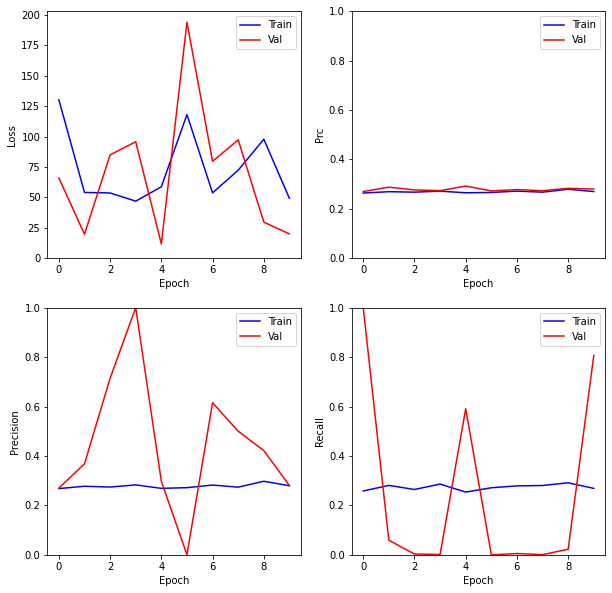

In [42]:
plot_history(history_model4b_inresnet)

-----TEST--------
8/8 [==============================] - 12s 718ms/step - loss: 20.0397 - tp: 857.0000 - fp: 2135.0000 - tn: 639.0000 - fn: 191.0000 - accuracy: 0.3914 - precision: 0.2864 - recall: 0.8177 - auc: 0.5260 - prc: 0.2860
loss :  20.039682388305664
tp :  857.0
fp :  2135.0
tn :  639.0
fn :  191.0
accuracy :  0.39141809940338135
precision :  0.2864304780960083
recall :  0.8177480697631836
auc :  0.5259573459625244
prc :  0.28604573011398315
-------------
-----VAL--------
12/12 [==============================] - 7s 554ms/step - loss: 20.0975 - tp: 1260.0000 - fp: 3238.0000 - tn: 976.0000 - fn: 298.0000 - accuracy: 0.3874 - precision: 0.2801 - recall: 0.8087 - auc: 0.5221 - prc: 0.2800
loss :  20.097463607788086
tp :  1260.0
fp :  3238.0
tn :  976.0
fn :  298.0
accuracy :  0.38738739490509033
precision :  0.2801244854927063
recall :  0.8087291121482849
auc :  0.5220530033111572
prc :  0.28003597259521484
-------------
8/8 [==============================] - 8s 630ms/step
3822
tf

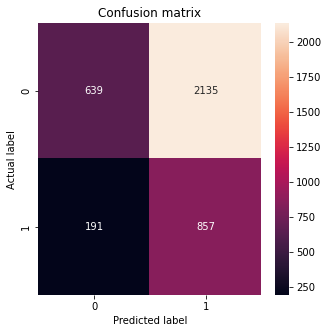

In [43]:
bmodel_eval(model4b_inresnet, 'Model4b InceptionResnetV2')